In [1]:
!pip install keras-bert
!pip install livelossplot

  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=82bff67593536ea29c16c7bbc8e2de16c56cc5158e15145004048e403eab6c95
  Stored in directory: /root/.cache/pip/wheels/a4/e8/45/842b3a39831261aef9154b907eacbc4ac99499a99ae829b06f
  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12305 sha256=640475373de97fa0a04899d812462993adb8cf5983479a4f8d704de7e595bd93
  Stored in directory: /root/.cache/pip/wheels/46/68/26/692ed21edd832833c3b0a0e21615bcacd99ca458b3f9ed571f
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.10.0-py3-none-any.whl size=3960 sha256=ad52002fcf4c28d70f13706111af7307f54f55eab43f826d3eadca5b6403e1d3
  Stored in directory: /root/.cache/pip/wheels/81/67/b5/d847588d075895281e1cf5590f819bd4cf076a554872268bd5
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4668 sha256=187c958bdec5bf0792811aa96e30159a803fd87eee77f784464a41ff

In [2]:
!nvidia-smi
!cat /proc/cpuinfo | grep 'model name' |uniq
!cat /proc/meminfo | grep MemTotal
!fdisk -l | grep Disk

Wed Mar 23 03:39:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import codecs, gc
import numpy as np
from sklearn.model_selection import KFold
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
from keras.metrics import top_k_categorical_accuracy
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
import keras.backend as K
from keras.optimizer_v2 import adam as adam_v2
from tensorflow.keras.utils import to_categorical
from livelossplot.keras import PlotLossesCallback

In [4]:
!unzip /content/drive/MyDrive/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16.zip

Archive:  /content/drive/MyDrive/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16.zip
  inflating: bert_config.json        
  inflating: bert_model.ckpt.data-00000-of-00001  
  inflating: bert_model.ckpt.index   
  inflating: bert_model.ckpt.meta    
  inflating: vocab.txt               


In [3]:
maxlen = 200 #
config_path = "/content/bert_config.json"
checkpoint_path = "/content/bert_model.ckpt"
dict_path = "/content/vocab.txt"

In [5]:
train_df=pd.read_csv('https://raw.githubusercontent.com/OOPPs123/data/main/label.csv', sep=',')
test_df=pd.read_csv('https://raw.githubusercontent.com/OOPPs123/data/main/reply2022-03-20.csv', sep=',')

In [6]:
train_df.head()

,comment,sentiment
0,妞妞屁股就能百万粉的时代真的比鞭炮炸lan子的时代好吗我觉得未必金陵纵有千种风情也不如虎弟惊鸿一瞥,0
1,感谢找了好久的官方MV,2
2,契诃夫说过如果故事里出现一把枪那它就非发射不可我的故事里出现了沈阳那我就非整个狠活儿不可,0
3,这个视频我看了不下50次最初点进去是抱着无厘头的态度看一个搞笑的抽象作品的可没想到我被彻底的...,2
4,看完了up的视频我痛哭流涕生活真是如此美好与浪漫,2


In [8]:
test_df.head()

,text
0,干得好另IsabelHilton这个ChinaDialogue的创立者2006年是从开放民主...
1,记得在海洋里面捞出来过监视器那么不吃就不捞
2,回形针已经被打上黄标了请别放过giegie
3,我们老校长说过鱼界所至海权所在也刻骨铭心啊
4,这波啊这波是人没钓鱼鱼自己送上门


In [9]:
def pretreatment(comments):
    result_comments=[]
    punctuation='。，？！：%&~（）、；“”&|,.?!:%&~();""[]【】//@·'
    for comment in comments:
        comment= ''.join([c for c in comment if c not in punctuation])
        comment= ''.join(comment.split())   #\xa0
        result_comments.append(comment)
    
    return result_comments

In [10]:
# replace=pretreatment(list(train_df['comment'].values))

In [11]:
# train_df['comment']=replace

In [7]:
train_df.head()

,comment,sentiment
0,妞妞屁股就能百万粉的时代真的比鞭炮炸lan子的时代好吗我觉得未必金陵纵有千种风情也不如虎弟惊鸿一瞥,0
1,感谢找了好久的官方MV,2
2,契诃夫说过如果故事里出现一把枪那它就非发射不可我的故事里出现了沈阳那我就非整个狠活儿不可,0
3,这个视频我看了不下50次最初点进去是抱着无厘头的态度看一个搞笑的抽象作品的可没想到我被彻底的...,2
4,看完了up的视频我痛哭流涕生活真是如此美好与浪漫,2


In [8]:
token_dict = {}
with codecs.open(dict_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

In [9]:
class OurTokenizer(Tokenizer):
    def _tokenize(self, text):
        R = []
        for c in text:
            if c in self._token_dict:
                R.append(c)
            elif self._is_space(c):
                R.append('[unused1]')  # 用[unused1]来表示空格类字符
            else:
                R.append('[UNK]')  # 不在列表的字符用[UNK]表示
        return R
tokenizer = OurTokenizer(token_dict)

In [10]:
#文本需要统一长度
def seq_padding(X, padding=0):
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])

In [11]:
class data_generator:
    def __init__(self, data, batch_size=8, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1
 
    def __len__(self):
        return self.steps
 
    def __iter__(self):
        while True:
            idxs = list(range(len(self.data)))
 
            if self.shuffle:
                np.random.shuffle(idxs)
 
            X1, X2, Y = [], [], []
            for i in idxs:
                d = self.data[i]
                text = d[0][:maxlen]
                x1, x2 = tokenizer.encode(first=text)
                y = d[1]
                X1.append(x1)
                X2.append(x2)
                Y.append([y])
                if len(X1) == self.batch_size or i == idxs[-1]:
                    X1 = seq_padding(X1)
                    X2 = seq_padding(X2)
                    Y = seq_padding(Y)
                    yield [X1, X2], Y[:, 0, :]
                    [X1, X2, Y] = [], [], []


In [12]:
def acc_top2(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [13]:
def build_model_LSTM(nclass):
    bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)
    for l in bert_model.layers:
        l.trainable = True
    x1_in = Input(shape=(None,))
    x2_in = Input(shape=(None,))
    # print("加载bert模型")
    x = bert_model([x1_in, x2_in])          # cls_layer = Lambda(lambda x: x[:, 0])(x) ## 取出[CLS]对应的向量用来做分类
    T = LSTM(128, return_sequences=False)(x) 
    T = Dropout(0.3)(T)
    output = Dense(nclass, activation='softmax')(T)
    model = Model([x1_in, x2_in], output)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=adam_v2.Adam(1e-5),
        metrics=['accuracy']
    )
    model.summary()
    return model

In [14]:
DATA_LIST = []
for data_row in train_df.iloc[:].itertuples():
    # print(data_row)
    DATA_LIST.append((data_row.comment, to_categorical(data_row.sentiment, 3)))
DATA_LIST = np.array(DATA_LIST)
 
DATA_LIST_TEST = []
for data_row in test_df.iloc[:].itertuples():
    # print(data_row)
    DATA_LIST_TEST.append((data_row.text, to_categorical(0, 3)))
DATA_LIST_TEST = np.array(DATA_LIST_TEST)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


In [15]:
def run_cv(nfold, data, data_labels, data_test):
    kf = KFold(n_splits=nfold, shuffle=True, random_state=520).split(data)
    train_model_pred = np.zeros((len(data), 3))
    test_model_pred = np.zeros((len(data_test), 3))
 
    for i, (train_fold, test_fold) in enumerate(kf):
        X_train, X_valid, = data[train_fold, :], data[test_fold, :]
 
        model = build_model_LSTM(3)
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)   #早停法，防止过拟合
        plateau = ReduceLROnPlateau(monitor="val_accuracy", verbose=1, mode='max', factor=0.5, patience=2) #当评价指标不在提升时，减少学习率
        checkpoint = ModelCheckpoint('/content/drive/MyDrive/model_save/LSTM_BERT' + str(i) + '.hdf5', monitor='val_accuracy',verbose=2, save_best_only=True, mode='max', save_weights_only=True) #保存最好的模型
 
        train_D = data_generator(X_train, shuffle=True)
        valid_D = data_generator(X_valid, shuffle=True)
        test_D = data_generator(data_test, shuffle=False)
        #模型训练
        model.fit_generator(
            train_D.__iter__(),
            steps_per_epoch=len(train_D),
            epochs=5,
            validation_data=valid_D.__iter__(),
            validation_steps=len(valid_D),
            callbacks=[early_stopping, plateau, checkpoint,PlotLossesCallback()],
        )
 
        # model.load_weights('./bert_dump/' + str(i) + '.hdf5')
 
        # return model
        train_model_pred[test_fold, :] = model.predict_generator(valid_D.__iter__(), steps=len(valid_D), verbose=1)
        test_model_pred += model.predict_generator(test_D.__iter__(), steps=len(test_D), verbose=1)
 
        # del model
        gc.collect()   #清理内存
        K.clear_session()   #clear_session就是清除一个session
        # break
 
    return train_model_pred, test_model_pred

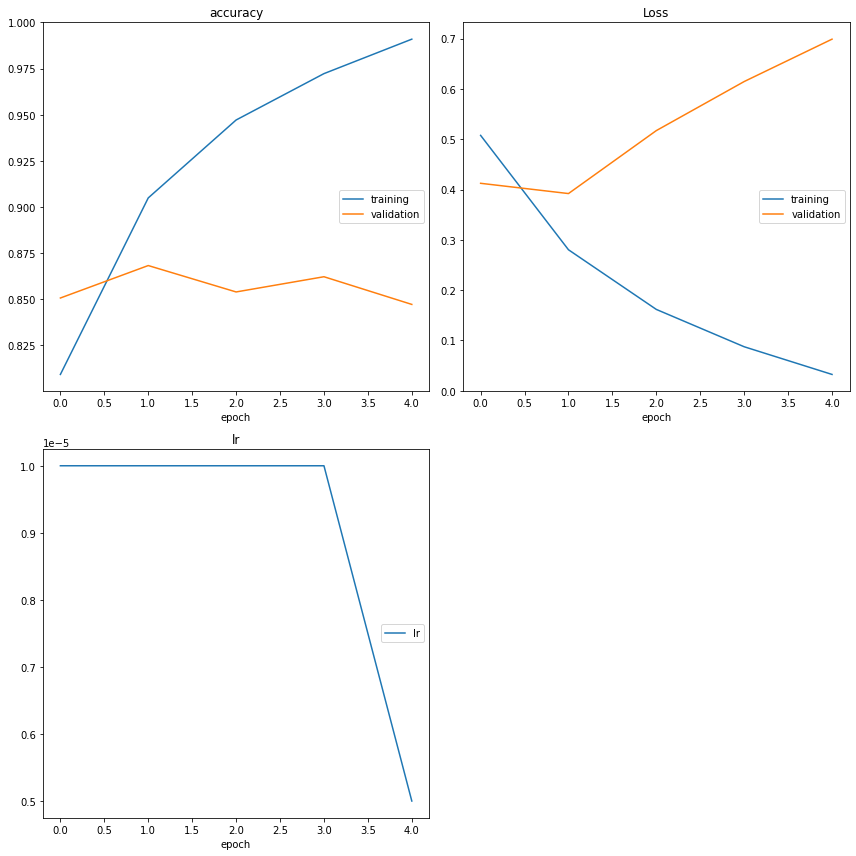

accuracy
	training         	 (min:    0.809, max:    0.991, cur:    0.991)
	validation       	 (min:    0.847, max:    0.868, cur:    0.847)
Loss
	training         	 (min:    0.032, max:    0.508, cur:    0.032)
	validation       	 (min:    0.392, max:    0.699, cur:    0.699)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
1524/1524 [==============================] - 110s 72ms/step


In [17]:
train_model_pred, test_model_pred = run_cv(2, DATA_LIST, None, DATA_LIST_TEST)

In [18]:
test_pred = [np.argmax(x) for x in test_model_pred]

In [20]:
output=pd.DataFrame({'id':test_df.text,'sentiment':test_pred})
output.to_csv('./results.csv', index=None)